### How does ratio between frac. of variance explained by conf and pref change between trial intervals? Is it consistent across regions?

In [6]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.visualization_utils as visualization_utils
import utils.anova_utils as anova_utils
import utils.spike_utils as spike_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
import itertools
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
MODE_TO_COND = {
    "pref": "BeliefPref",
    "conf": "BeliefConf",
    "choice": "Choice",
    "reward": "Response"
}
MODES = ["pref", "conf"]
REGIONS = [None, "amygdala_Amy", "basal_ganglia_BG", "inferior_temporal_cortex_ITC", "medial_pallium_MPal", "lateral_prefrontal_cortex_lat_PFC", "anterior_cingulate_gyrus_ACgG"]

In [8]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.sig_thresh = "99th"

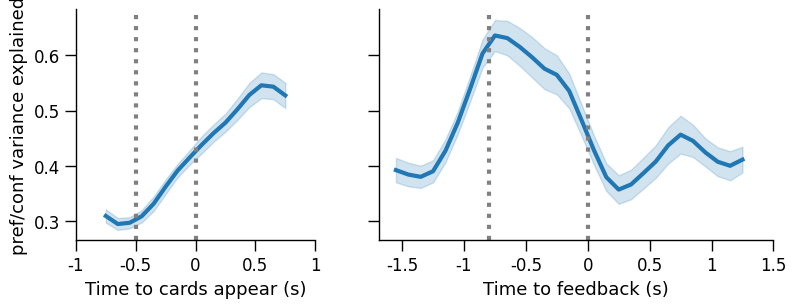

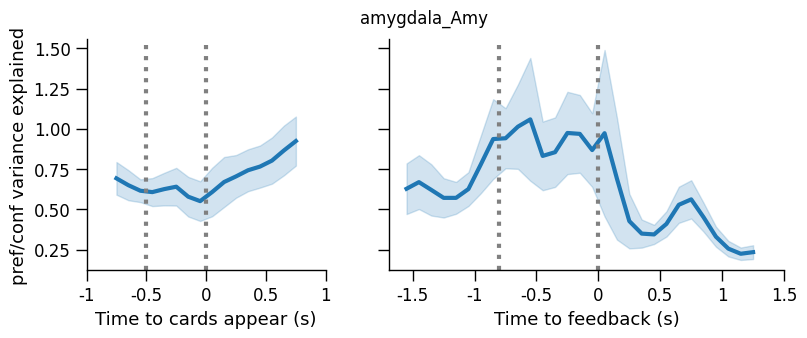

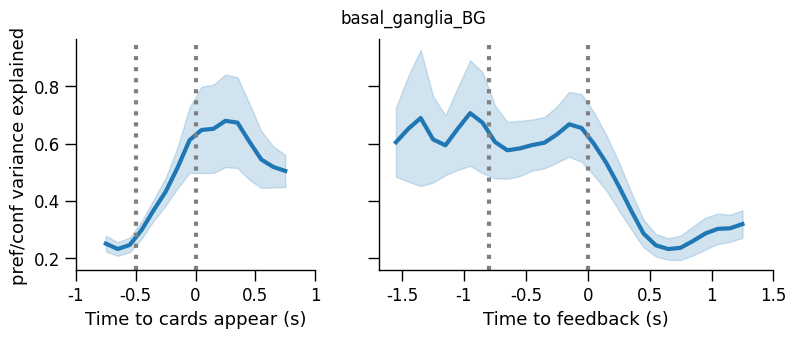

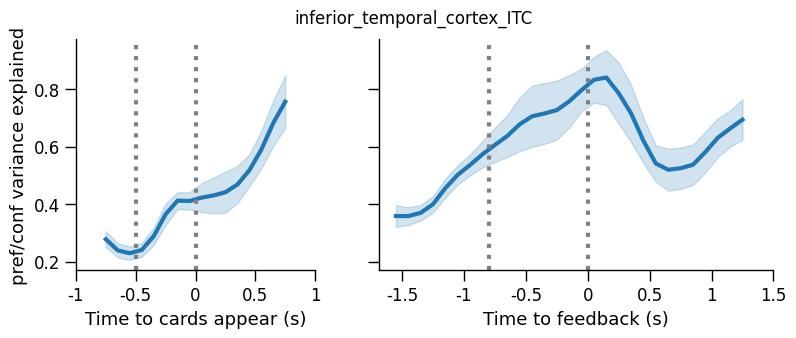

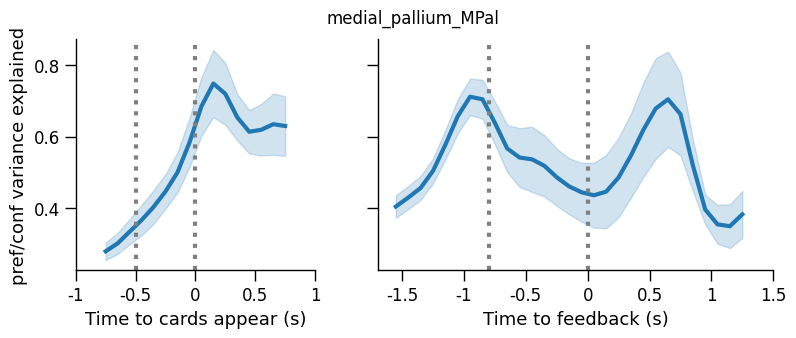

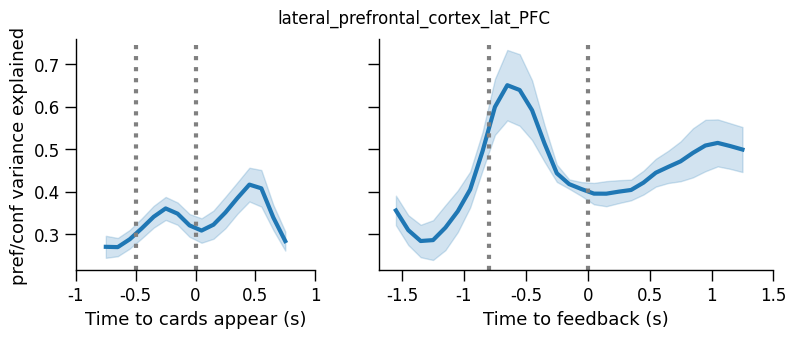

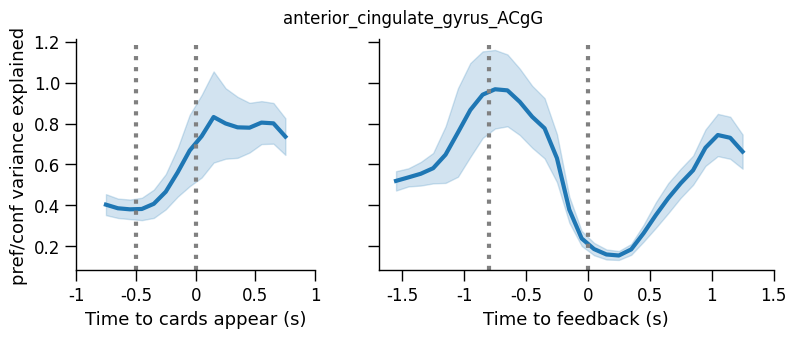

In [10]:
for region in REGIONS: 
    region_units = spike_utils.get_all_region_units("structure_level2_cleaned", region, filter_drift=True)
    conf_frac_var = anova_utils.frac_var_explained_by_time(args, [MODE_TO_COND["conf"]], units=region_units)
    pref_frac_var = anova_utils.frac_var_explained_by_time(args, [MODE_TO_COND["pref"]], units=region_units)
    merged = pd.merge(conf_frac_var, pref_frac_var, on=["feat", "WindowEndMilli", "trial_event"], suffixes=["_conf", "_pref"])
    merged["ratio"] = merged["frac_variance_pref"] / merged["frac_variance_conf"]
    merged["Time"] = merged.WindowEndMilli / 1000 - 0.25 # the middle of the 500ms window 

    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey='row', width_ratios=[20, 33])
    for i, event in enumerate(["StimOnset", "FeedbackOnsetLong"]):
        trial_res = merged[merged.trial_event == event]
        sns.lineplot(
            trial_res, x="Time", y="ratio", 
            linewidth=3, ax=axs[i], errorbar="se"
        )
    ax1, ax2 = axs
    ax1.axvline(-.5, color='grey', linestyle='dotted', linewidth=3)
    ax1.axvline(0, color='grey', linestyle='dotted', linewidth=3)
    ax2.axvline(-.8, color='grey', linestyle='dotted', linewidth=3)
    ax2.axvline(0, color='grey', linestyle='dotted', linewidth=3)
    ax1.set_ylabel("pref/conf variance explained")
    ax1.set_xlabel(f"Time to cards appear (s)")
    stim_ticks = [-1, -.5, 0, .5, 1]
    ax1.set_xticks(stim_ticks)
    ax1.set_xticklabels(stim_ticks)

    ax2.set_xlabel(f"Time to feedback (s)")
    fb_ticks = [-1.5, -1, -.5, 0, .5, 1, 1.5]
    ax2.set_xticks(fb_ticks)
    ax2.set_xticklabels(fb_ticks)
    fig.suptitle(region)
    visualization_utils.format_plot(axs)
